# Binary Classification of NSL-KDD Dataset

In [63]:
# For getting paths
import os

# For data manipulation and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# For feature engineering
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# For model building
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For model evaluation
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, classification_report

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For timing
import time

# Tensorflow and Keras
import tensorflow as tf
import time

## Dataset Visualization and Preprocessing

In [64]:
# Column Labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

# Datasets
train_path = "../datasets/nsl-kdd/KDDTrain+.txt"
test_path = "../datasets/nsl-kdd/KDDTest+.txt"

df_train=pd.read_csv(train_path,header=None,names=columns)
df_test=pd.read_csv(test_path,header=None,names=columns)

In [65]:
# Training Set Preview
print(df_train.shape)
print("--------------------")
print(df_train.head())
print("--------------------")
print(df_train.info())

(125973, 43)
--------------------
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60             

In [66]:
# Testing Set Preview
print(df_test.shape)
print("--------------------")
print(df_test.head())
print("--------------------")
print(df_test.info())

(22544, 43)
--------------------
   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.04   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.61   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    0.31   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.06                         0.00   
1                    0.06        

In [67]:
# Check for duplicates
print("Duplicates in Train: ", df_train.duplicated().sum())
print("Duplicates in Test: ", df_test.duplicated().sum())

# Check for missing values
print("-----------------------------------")
print("Rows with missing values - train: ", df_train.isnull().sum())
print("-----------------------------------")
print("Rows with missing values - test: ", df_test.isnull().sum())

Duplicates in Train:  0
Duplicates in Test:  0
-----------------------------------
Rows with missing values - train:  duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate             

In [68]:
df_train_binary = df_train.copy()

df_train_binary['attack'] = df_train_binary['attack'].apply(
    lambda x: 'attack' if x != 'normal' else 'normal'
)

df_test_binary = df_test.copy()

df_test_binary['attack'] = df_test_binary['attack'].apply(
    lambda x: 'attack' if x != 'normal' else 'normal'
)

In [69]:
# Helper function to plot bar labels
def add_bar_labels(bars):
    # Add counts on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height}',
            ha='center',
            va='bottom'
        )

In [70]:
# Binary encoding for 'attack' column
le_attack = LabelEncoder()
df_train_binary['attack'] = le_attack.fit_transform(df_train_binary['attack'])
df_test_binary['attack'] = df_test_binary['attack'].apply(lambda x: le_attack.transform([x])[0] if x in le_attack.classes_ else -1)

# Encode other categorical features
columns_to_encode = ['protocol_type', 'service', 'flag']
label_map = {}

for column in columns_to_encode:
    le = LabelEncoder()
    le.fit(df_train_binary[column])
    df_train_binary[column] = le.transform(df_train_binary[column])
    df_test_binary[column] = df_test_binary[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    label_map[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Display the label map
for column, mapping in label_map.items():
    print(f"Mapping for {column}: {mapping}")

# Display encoded DataFrames
print("\nEncoded df_train:")
print(df_train_binary)

print("\nEncoded df_test:")
print(df_test_binary)

Mapping for protocol_type: {'icmp': 0, 'tcp': 1, 'udp': 2}
Mapping for service: {'IRC': 0, 'X11': 1, 'Z39_50': 2, 'aol': 3, 'auth': 4, 'bgp': 5, 'courier': 6, 'csnet_ns': 7, 'ctf': 8, 'daytime': 9, 'discard': 10, 'domain': 11, 'domain_u': 12, 'echo': 13, 'eco_i': 14, 'ecr_i': 15, 'efs': 16, 'exec': 17, 'finger': 18, 'ftp': 19, 'ftp_data': 20, 'gopher': 21, 'harvest': 22, 'hostnames': 23, 'http': 24, 'http_2784': 25, 'http_443': 26, 'http_8001': 27, 'imap4': 28, 'iso_tsap': 29, 'klogin': 30, 'kshell': 31, 'ldap': 32, 'link': 33, 'login': 34, 'mtp': 35, 'name': 36, 'netbios_dgm': 37, 'netbios_ns': 38, 'netbios_ssn': 39, 'netstat': 40, 'nnsp': 41, 'nntp': 42, 'ntp_u': 43, 'other': 44, 'pm_dump': 45, 'pop_2': 46, 'pop_3': 47, 'printer': 48, 'private': 49, 'red_i': 50, 'remote_job': 51, 'rje': 52, 'shell': 53, 'smtp': 54, 'sql_net': 55, 'ssh': 56, 'sunrpc': 57, 'supdup': 58, 'systat': 59, 'telnet': 60, 'tftp_u': 61, 'tim_i': 62, 'time': 63, 'urh_i': 64, 'urp_i': 65, 'uucp': 66, 'uucp_path':

In [71]:
# "land," since this would have to be a check to see if src ip = dest ip
non_directly_obtainable_features = [
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'land',
    'level',   
]

X_train = df_train_binary.drop(non_directly_obtainable_features, axis=1)
X_test = df_test_binary.drop(non_directly_obtainable_features, axis=1)

In [72]:
# Split the data into features (x) and target (y) - Level is unknown in real-time
X_train = X_train.drop('attack', axis=1)
y_train = df_train_binary['attack']
X_test = X_test.drop('attack', axis=1)
y_test = df_test_binary['attack']

In [73]:
# Ratio of Training to Testing Data
# Step 1: Determine the sizes of training and test sets
train_size = len(df_train_binary)
test_size = len(df_test_binary)

# Step 2: Calculate the total number of samples
total_size = train_size + test_size

# Step 3: Calculate the ratios
train_ratio = train_size / total_size
test_ratio = test_size / total_size

print(f"Train ratio: {train_ratio:.2f}")
print(f"Test ratio: {test_ratio:.2f}")


Train ratio: 0.85
Test ratio: 0.15


### Feature Engineering

In [75]:
# SelectKBest for Top 20 Features
top_20_features = SelectKBest(mutual_info_classif, k=4)
top_20_features.fit(X_train, y_train)
X_train.columns[top_20_features.get_support()]

Index(['service', 'src_bytes', 'dst_bytes', 'same_srv_rate'], dtype='object')

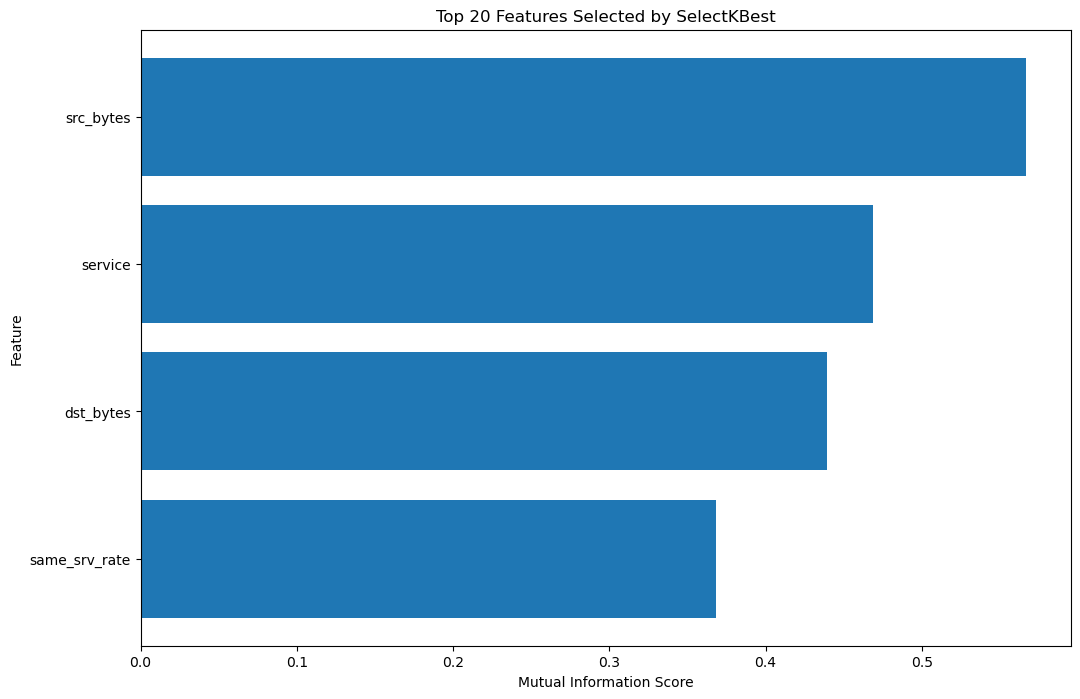

In [76]:
# Get the mask for the selected features
mask = top_20_features.get_support()

# Get the feature scores
feature_scores = top_20_features.scores_

# Get the selected feature names
selected_features = X_train.columns[mask]
selected_scores = feature_scores[mask]

# Create a DataFrame for plotting
df_top_features = pd.DataFrame({
    'Feature': selected_features,
    'Score': selected_scores
})

# Sort the DataFrame by scores in descending order
df_top_features = df_top_features.sort_values(by='Score', ascending=False)

# Plot the top features
plt.figure(figsize=(12, 8))
plt.barh(df_top_features['Feature'], df_top_features['Score'])
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top 20 Features Selected by SelectKBest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()


In [16]:
top_20_features = ['service', 'src_bytes', 'dst_bytes', 'same_srv_rate']

       # ['service', 'flag', 'src_bytes', 'dst_bytes', 'same_srv_rate',
       # 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       # 'dst_host_diff_srv_rate', 'dst_host_serror_rate']
       # ['service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'srv_count',
       # 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'diff_srv_rate',
       # 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       # 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       # 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       # 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       # 'dst_host_srv_rerror_rate']

X_train = X_train[top_20_features]
X_test = X_test[top_20_features]

### Scale Data

In [77]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
sampled = False

## ML Results

In [78]:
import joblib

# Create the classifiers
models = {
    "XGBoost": XGBClassifier(
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Decision Tree": DecisionTreeClassifier(),
}


# Train and evaluate each model
results = {}

for name, model in models.items():
    # Train the model
    start_train_time = time.time()
    model.fit(X_train, y_train)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time

    # Save the trained model
    # model_filename = f"{name.replace(' ', '_').lower()}_binary_model.joblib"
    # joblib.dump(model, model_filename)
    # print(f"Model {name} saved as {model_filename}")

    # Predict on the test set
    start_pred_time = time.time()
    y_pred = model.predict(X_test)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time

    # Decode labels for evaluation
    y_test_decoded = le.inverse_transform(y_test)
    y_pred_decoded = le.inverse_transform(y_pred)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
    precision = precision_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    recall = recall_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro', zero_division=1)
    conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
    class_report = classification_report(y_test_decoded, y_pred_decoded, zero_division=1)

    # Store the results
    results[name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "conf_matrix": conf_matrix,
        "class_report": class_report,
        "train_time": train_time,
        "pred_time": pred_time
    }

    # Print evaluation metrics
    print(f'--- {name} ---')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Classification Report:\n{class_report}')
    print(f'Training Time: {train_time} seconds')
    print(f'Prediction Time: {pred_time} seconds')


--- XGBoost ---
Accuracy: 0.7998580553584103
Precision: 0.8290554812677156
Recall: 0.8205957517859532
F1 Score: 0.7995967841556387
Confusion Matrix:
[[8609 4224]
 [ 288 9423]]
Classification Report:
              precision    recall  f1-score   support

         OTH       0.97      0.67      0.79     12833
         REJ       0.69      0.97      0.81      9711

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.80     22544

Training Time: 0.36070799827575684 seconds
Prediction Time: 0.005614757537841797 seconds
--- Logistic Regression ---
Accuracy: 0.7522178850248403
Precision: 0.7861616567474112
Recall: 0.7743789516882043
F1 Score: 0.75152555414626
Confusion Matrix:
[[7884 4949]
 [ 637 9074]]
Classification Report:
              precision    recall  f1-score   support

         OTH       0.93      0.61      0.74     12833
         REJ       0.65      0.93      0.76      9711

    accuracy

In [79]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, model_name, le_attack):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_attack.classes_, yticklabels=le_attack.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

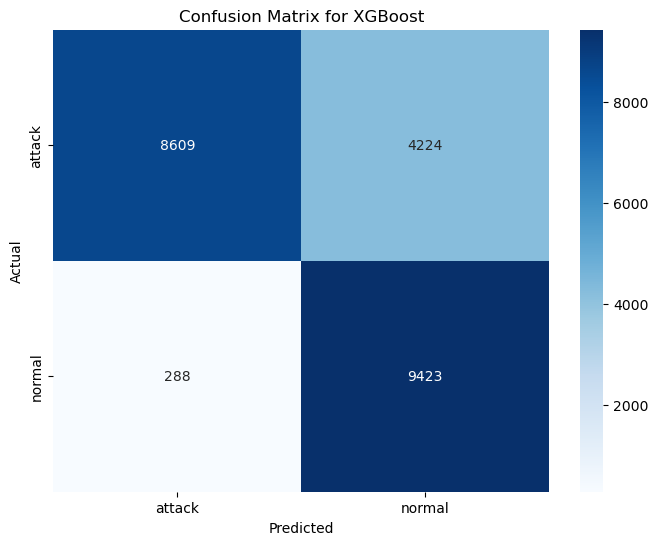

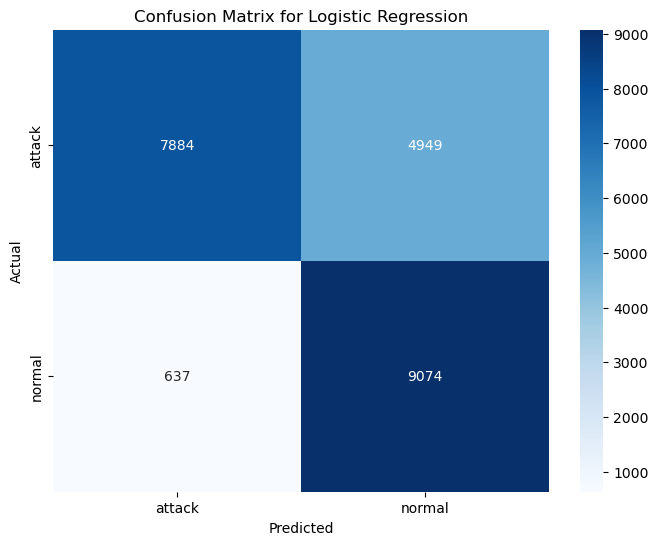

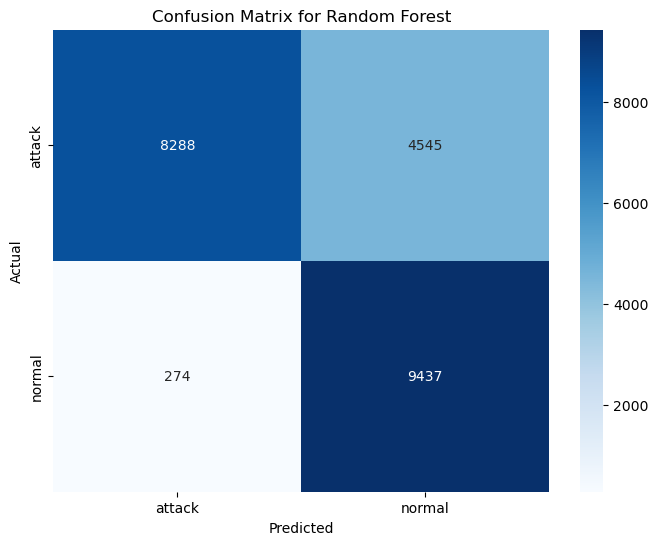

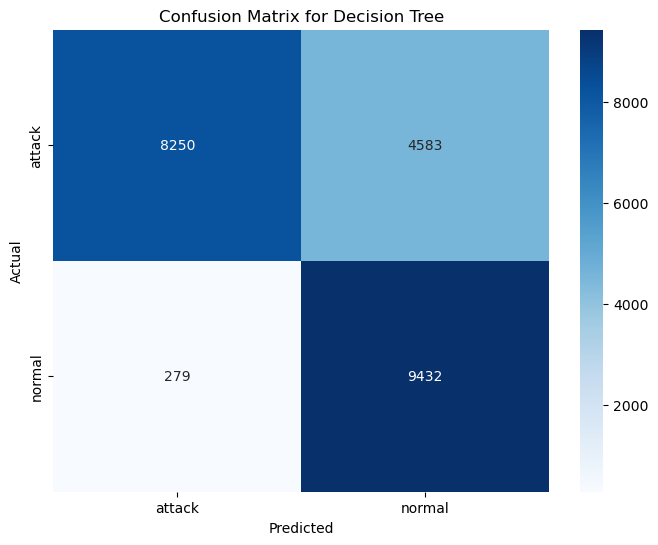

In [80]:
# Plot the confusion matrix for each model
for model_name, metrics in results.items():
    plot_confusion_matrix(metrics['conf_matrix'], model_name, le_attack)

In [81]:
# Print the mapping of labels
print("Label mapping for 'attack':")
for i, label in enumerate(le_attack.classes_):
    print(f"{i}: {label}")

Label mapping for 'attack':
0: attack
1: normal


## DL Results

In [82]:
# Reshape x_train and x_test to 3D for CNN-LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # shape becomes (125973, 20, 1)
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))      # shape becomes (22544, 20, 1)


In [96]:
print(X_train_reshaped.shape)

(125973, 27, 1)


In [83]:
import tensorflow as tf

cnn_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], 1)),

    # CNN Layers with L2 Regularization
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    # LSTM Layers
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100),

    # Fully Connected Layers
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Output layer for binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
cnn_lstm_model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)              │ (None, 25, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 10, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 5, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,953 (749.82 KB)

 Trainable params: 191,953 (749.82 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
import time

# Record the start time
start_time = time.time()

# Train the model
history = cnn_lstm_model.fit(X_train_reshaped, y_train, epochs=30, batch_size=64, validation_split=0.2)

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time:.2f} seconds")

# Save the trained model to a file
cnn_lstm_model.save('cnn_lstm_model_binary.keras')  
print("Model saved as 'cnn_lstm_model_binary.keras'")

Epoch 1/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9428 - loss: 0.1634 - val_accuracy: 0.9835 - val_loss: 0.0497
Epoch 2/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9810 - loss: 0.0511 - val_accuracy: 0.9878 - val_loss: 0.0349
Epoch 3/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9864 - loss: 0.0373 - val_accuracy: 0.9894 - val_loss: 0.0339
Epoch 4/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9888 - loss: 0.0319 - val_accuracy: 0.9896 - val_loss: 0.0301
Epoch 5/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9901 - loss: 0.0265 - val_accuracy: 0.9927 - val_loss: 0.0196
Epoch 6/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9915 - loss: 0.0231 - val_accuracy: 0.9927 - val_loss: 0.0196
Epoch 7/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9923 - loss: 0.0208 - val_accuracy: 0.9925 - val_loss: 0.0209
Epoch 8/30
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9928 - loss: 0

In [93]:
# Make predictions on the test data
start_pred_time = time.time()
y_pred = cnn_lstm_model.predict(X_test_reshaped)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time
print(f"Prediction time: {pred_time:.2f} seconds")

y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Decode labels for evaluation
y_test_decoded = le_attack.inverse_transform(y_test)
y_pred_decoded = le_attack.inverse_transform(y_pred_classes)

# Print the decoded predictions and true labels
print("Predicted Labels:", y_pred_decoded)
print("True Labels:", y_test_decoded)


705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Prediction time: 1.36 seconds
Predicted Labels: ['attack' 'attack' 'normal' ... 'normal' 'normal' 'attack']
True Labels: ['attack' 'attack' 'normal' ... 'attack' 'normal' 'attack']


In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='macro')
recall = recall_score(y_test_decoded, y_pred_decoded, average='macro')
f1 = f1_score(y_test_decoded, y_pred_decoded, average='macro')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision (macro-average): {precision:.5f}")
print(f"Recall (macro-average): {recall:.5f}")
print(f"F1 Score (macro-average): {f1:.5f}")

Accuracy: 0.74956
Precision (macro-average): 0.78404
Recall (macro-average): 0.77189
F1 Score (macro-average): 0.74881


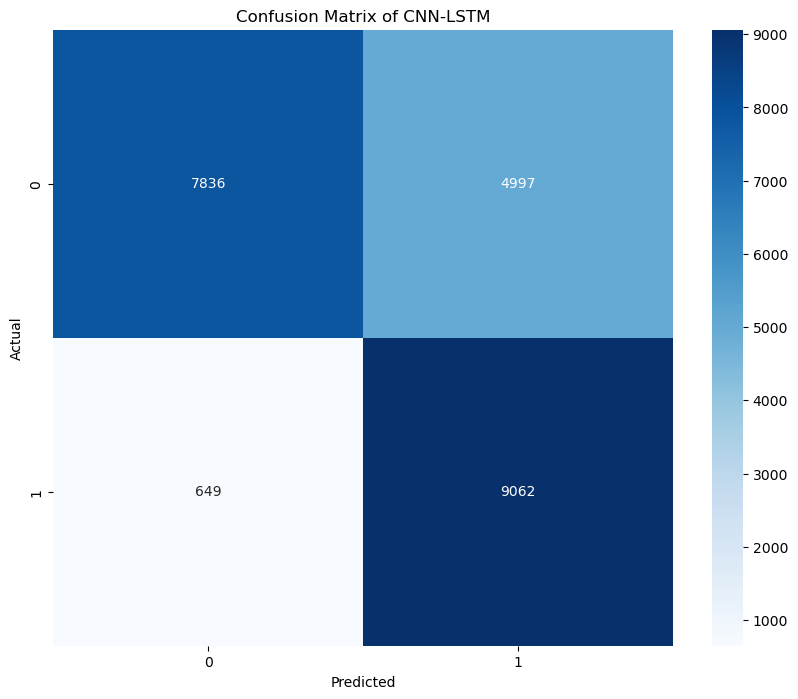

              precision    recall  f1-score   support

      attack    0.92351   0.61061   0.73515     12833
      normal    0.64457   0.93317   0.76247      9711

    accuracy                        0.74956     22544
   macro avg    0.78404   0.77189   0.74881     22544
weighted avg    0.80336   0.74956   0.74692     22544



In [89]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

# Define the number of classes (assuming le.classes_ gives the correct number of classes)
num_classes = len(le.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues') #, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of CNN-LSTM')
plt.show()

# Print the classification report
print(classification_report(y_test_decoded, y_pred_decoded, digits=5))


## Autoencoder

In [49]:
# Reshape the data for the autoencoder
balanced = False
if balanced:
    print("Balanced Version")
else:
    x_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  

x_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [50]:
# Get the input dimension
input_dim = x_train_reshaped.shape[1]
print(input_dim)

10


In [58]:
# Define the autoencoder model
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim, 1)),
    tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu', name='bottleneck'),
    tf.keras.layers.Dense(((input_dim // 4)) * 16, activation='relu'),
    tf.keras.layers.Reshape(((input_dim // 4), 16)),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    tf.keras.layers.UpSampling1D(2),
    tf.keras.layers.ZeroPadding1D(padding=1),
    tf.keras.layers.Conv1D(1, 3, activation='tanh', padding='same')
])

# Compile the autoencoder
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Print the model summary
print(autoencoder.summary())

# Extract the encoder part
encoder = tf.keras.Sequential(autoencoder.layers[:7])
encoder.build(input_shape=(None, input_dim, 1))
print(encoder.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 5, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 2, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_10 (UpSampling1D) │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 4, 16)          │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_11 (UpSampling1D) │ (None, 8, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d (ZeroPadding1D)  │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 10, 1)          │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,841 (15.00 KB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 10, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 5, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │           544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,008 (11.75 KB)

 Trainable params: 3,008 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [59]:
autoencoder_start_time = time.time()
# Train the autoencoder on both benign and attack samples
autoencoder.fit(
    x_train_reshaped, 
    x_train_reshaped, 
    epochs=50, 
    batch_size=64, 
    shuffle=True, 
    validation_split=0.2,
)
autoencoder_end_time = time.time()
autoencoder_training_time = autoencoder_end_time - autoencoder_start_time

Epoch 1/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3724 - val_loss: 0.3838
Epoch 2/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4501 - val_loss: 0.3734
Epoch 3/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5315 - val_loss: 0.3707
Epoch 4/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3352 - val_loss: 0.3678
Epoch 5/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2658 - val_loss: 0.3664
Epoch 6/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2664 - val_loss: 0.3662
Epoch 7/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2944 - val_loss: 0.3651
Epoch 8/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6784 - val_loss: 0.3650
Epoch 9/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4916 - val_loss: 0.3646
Epoch 10/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3061 - val_loss: 0.3651
Epoch 11/50
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4018 - val_loss: 0.3642
Epoch 12/50
1575/1575 ━━━━━━━━

In [60]:
# Encode the train and test data using the trained encoder
encoded_train = encoder.predict(x_train_reshaped)
encoded_test = encoder.predict(x_test_reshaped)

3937/3937 ━━━━━━━━━━━━━━━━━━━━ 1s 334us/step
705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


In [61]:
# Flatten the encoded data for training XGBoost
encoded_train_flat = encoded_train.reshape((encoded_train.shape[0], -1))
encoded_test_flat = encoded_test.reshape((encoded_test.shape[0], -1))

In [62]:
import time
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Ensure binary classification by setting the correct XGBoost objective
model = XGBClassifier(
    objective='binary:logistic',  # Binary classification objective
    eval_metric='logloss',        # Log loss for binary classification
    use_label_encoder=False
)

# Train the model
start_train_time = time.time()
model.fit(encoded_train_flat, y_train, verbose=True)
end_train_time = time.time()
train_time = end_train_time - start_train_time

# Save the trained AE-XGB model to a file
model_filename = "ae_xgb_model_binary.joblib"
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")

# Predict on the test set
start_pred_time = time.time()
y_pred = model.predict(encoded_test_flat)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time

# Decode labels for evaluation (not needed if your labels are already 0 and 1)
# Assuming `le.inverse_transform()` is used for multiclass, skip it for binary classification
# y_test_decoded = le.inverse_transform(y_test)
# y_pred_decoded = le.inverse_transform(y_pred)

# If your labels are already 0 and 1, use them directly for evaluation
y_test_decoded = y_test
y_pred_decoded = y_pred

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='binary', zero_division=1)
recall = recall_score(y_test_decoded, y_pred_decoded, average='binary', zero_division=1)
f1 = f1_score(y_test_decoded, y_pred_decoded, average='binary', zero_division=1)
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
class_report = classification_report(y_test_decoded, y_pred_decoded, digits=5, zero_division=1)

# Store the results
results = {}
results["AE-XGBoost"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "conf_matrix": conf_matrix,
    "class_report": class_report,
    "train_time": train_time,
    "pred_time": pred_time
}

# Print evaluation metrics
print(f'--- AE-XGBoost ---')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')
print(f'Training Time: {train_time} seconds')
print(f'Prediction Time: {pred_time} seconds')


Model saved as ae_xgb_model_binary.joblib
--- AE-XGBoost ---
Accuracy: 0.7879258339247693
Precision: 0.6775169235200922
Recall: 0.9687982700030893
F1 Score: 0.7973894986650846
Confusion Matrix:
[[8355 4478]
 [ 303 9408]]
Classification Report:
              precision    recall  f1-score   support

           0    0.96500   0.65106   0.77753     12833
           1    0.67752   0.96880   0.79739      9711

    accuracy                        0.78793     22544
   macro avg    0.82126   0.80993   0.78746     22544
weighted avg    0.84117   0.78793   0.78609     22544

Training Time: 0.4132521152496338 seconds
Prediction Time: 0.005023956298828125 seconds


In [68]:
# Calculate reconstruction error on the test set
reconstructions = autoencoder.predict(X_test)
reconstruction_error = tf.keras.losses.mse(X_test, reconstructions)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)  # Example: 95th percentile
anomalies = reconstruction_error > threshold

# Decode labels for evaluation
y_test_decoded = le_attack.inverse_transform(y_test)
anomalies_decoded = ['attack' if x else 'normal' for x in anomalies]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_decoded, anomalies_decoded)
precision = precision_score(y_test_decoded, anomalies_decoded, pos_label='attack', average='binary', zero_division=1)
recall = recall_score(y_test_decoded, anomalies_decoded, pos_label='attack', average='binary', zero_division=1)
f1 = f1_score(y_test_decoded, anomalies_decoded, pos_label='attack', average='binary', zero_division=1)
conf_matrix = confusion_matrix(y_test_decoded, anomalies_decoded)
class_report = classification_report(y_test_decoded, anomalies_decoded, zero_division=1)

# Print evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
Accuracy: 0.46371540099361247
Precision: 0.8319928507596068
Recall: 0.07254733889191928
F1 Score: 0.13345756880733944
Confusion Matrix:
[[  931 11902]
 [  188  9523]]
Classification Report:
              precision    recall  f1-score   support

      attack       0.83      0.07      0.13     12833
      normal       0.44      0.98      0.61      9711

    accuracy                           0.46     22544
   macro avg       0.64      0.53      0.37     22544
weighted avg       0.67      0.46      0.34     22544



In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, 'Autoencoder')